# CUBIC vs. Tahoe

In [my last blog post](http://www.squidarth.com/rc/programming/networking/2018/07/18/intro-congestion.html), I introduce the concept of congestion control and the Tahoe congestion control scheme.

In this notebook, I introduce a new algorithm: [CUBIC](https://tools.ietf.org/html/rfc8312), and evaluate its performance.

CUBIC is currently the default algorithm used in Linux, and implementations have existed since 2004.

### What are the problems with Tahoe?


To recap some of the concepts in congestion control--the main thing that congestion control algorithms control is is the **congestion window**, which is the number of packets that the congestion control algorithm will keep in flight at any given point in time. The optimal congestion window to have is the amount of packets that will fit on the particular link you are sending on, which is the BDP (Bandwidth-delay product, computed as the product of the delay on a network with the bandwidth).

Tahoe was devised in 1988, and since then, a lot has changed on the internet. Notably, there are much more high BDP links than there were back then. To fully take advantage of these high BDP links, senders need to send with a much higher congestion window.

As I discuss in the last blog post, once Tahoe has crossed the "slow start threshold", it begins to grow the size of the congestion window linearly. While this is fine on low BDP links, on higher BDP links, it takes longer to converge, and will end up not performing optimally.

### Introducing: CUBIC

In order to perform better on these high bandwidth links, we need to solve two main problems:

1. Growing the congestion window faster so that we can take more advantage of the bandwidth
2. Back off on growing the window as quickly to not be unfair to traditional TCP algorithms

From these two problems, it seems like we'd want to have a multi-phase algorithm that alternately probes for more
bandwidth, and then once the available bandwidth has been discovered, grows slowly up to that discovered bandwidth.

It turns out that there is a function that satisfies this "multi-phase" requirement, the cubic function!

![cubic function](cubic_function.png)

The rough sketch of the CUBIC congestion control algorithm is that it has a "concave" phase (before the inflection point), and a "convex" phase (after the inflection point).

It starts out by growing the congestion window quickly,
slows down around a value called `w_max`. The window grows very slowly around `w_max`, and if no packet loss happens, it starts growing quickly in order to probe for more bandwidth. Once packet loss is experienced, `w_max`
is set to be the window size when the loss happened.

In each of these experiments, I print out the throughput of the algorithm, along with graphs of the link queue size
over time, the RTTs over time, and the congestion window over time.

### Getting set up with this notebook:

All of the code for this project is at this repo.

I've only tested this on Ubuntu--if you are using MacOS or another operating system, I highly suggest using Vagrant to spin up a VM.

```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install -r requirements.txt

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
$ sudo sysctl -w net.core.rmem_default=26214400
$ sudo sysctl -w net.core.rmem_max=26214400
```

### Usage

Scroll down to the bottom of the notebook to see full examples, but here's a quick start:

```python
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])
```

The run_with_mahi_settings function takes some settings, notably a delay, trace_file, and queue options, along with a number of seconds that it should run for and a congestion control strategy, and then prints out some statistics on what happened. What this does is create a single sender/receiver pair that send UDP packets to one another over the mahimahi boundary.

This UDP connection, while not actually TCP, is a decent way of simulating how TCP would perform over those network conditions, with the selected strategy.

In [1]:
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import SenderStrategy, FixedWindowStrategy, TahoeStrategy, CubicStrategy

# Low BDP Link -- Tahoe

[sender] Connected to receiver: 100.64.0.2:39268

Results for sender 47018:
Total Acks: 19763
Num Duplicate Acks: 372
% duplicate acks: 1.882305
Throughput (bytes/s): 12927.333333
Average RTT (ms): 238.647447


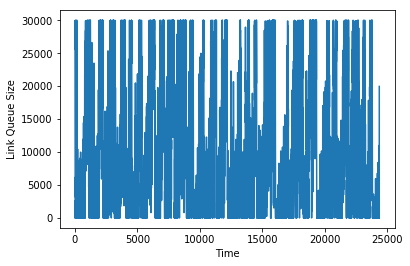

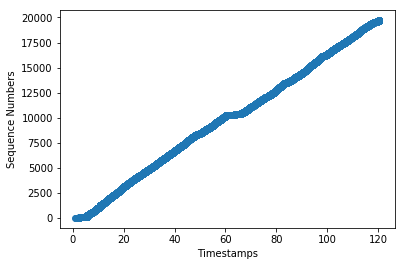

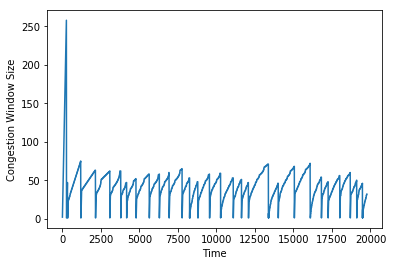

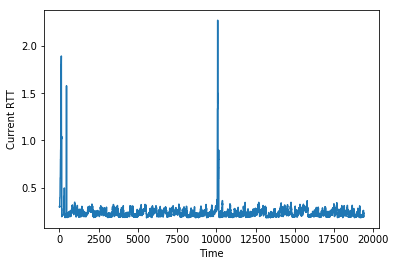

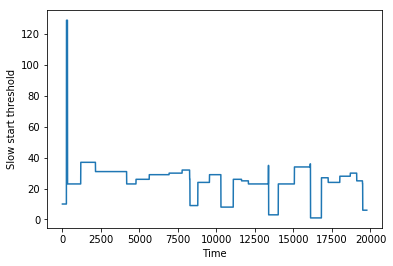

In [2]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# Low BDP Link -- CUBIC

[sender] Connected to receiver: 100.64.0.2:40500

Results for sender 51699:
Total Acks: 21242
Num Duplicate Acks: 738
% duplicate acks: 3.474249
Throughput (bytes/s): 13669.333333
Average RTT (ms): 255.006998


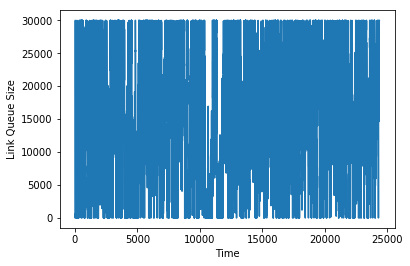

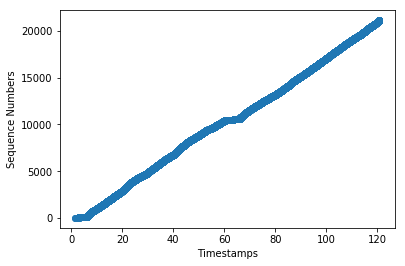

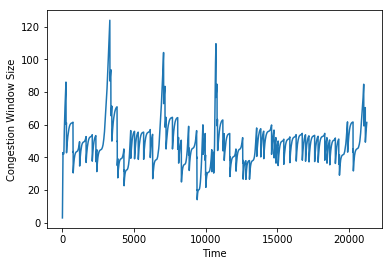

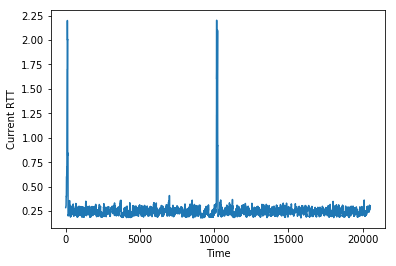

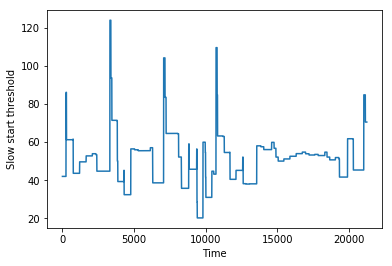

In [3]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# High BDP Link -- Tahoe

[sender] Connected to receiver: 100.64.0.2:37427

Results for sender 55331:
Total Acks: 16381
Num Duplicate Acks: 303
% duplicate acks: 1.849704
Throughput (bytes/s): 10718.666667
Average RTT (ms): 432.266676


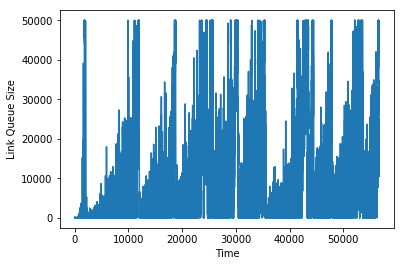

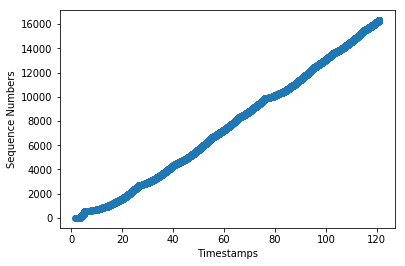

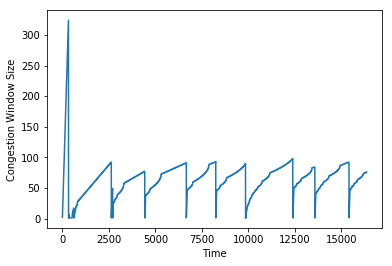

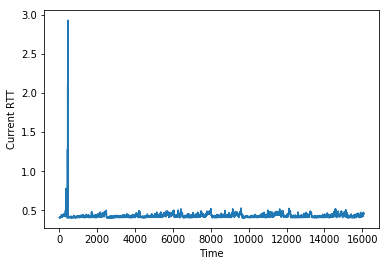

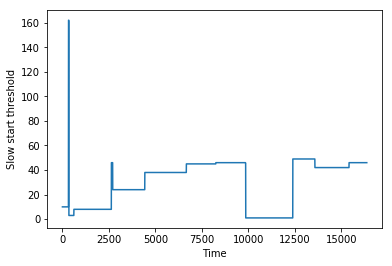

In [4]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# High BDP Link -- CUBIC

[sender] Connected to receiver: 100.64.0.2:60544

Results for sender 38499:
Total Acks: 23867
Num Duplicate Acks: 1236
% duplicate acks: 5.178699
Throughput (bytes/s): 15087.333333
Average RTT (ms): 443.842862


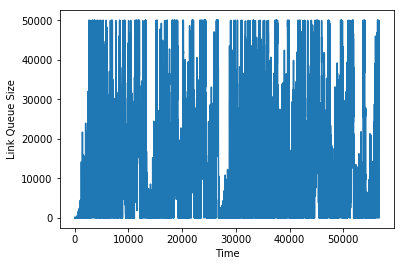

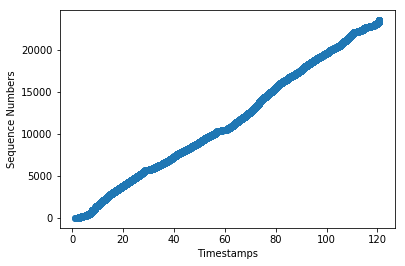

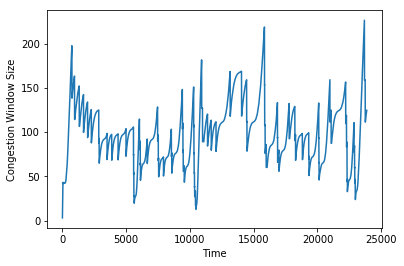

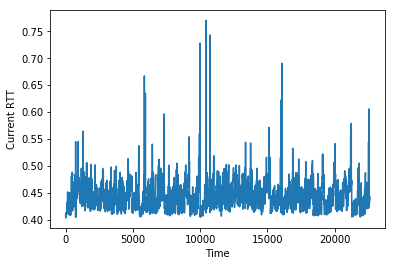

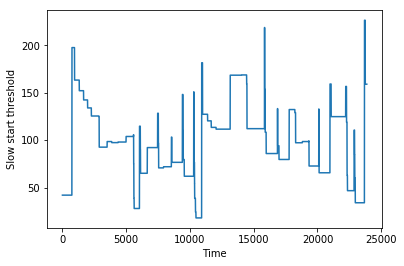

In [5]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# Fairness - CUBIC vs. Tahoe (Low BDP)

[sender] Connected to receiver: 100.64.0.2:57740

[sender] Connected to receiver: 100.64.0.2:57740

Results for sender 48005:
Total Acks: 24310
Num Duplicate Acks: 845
% duplicate acks: 3.475936
Throughput (bytes/s): 15643.333333
Average RTT (ms): 246.331577


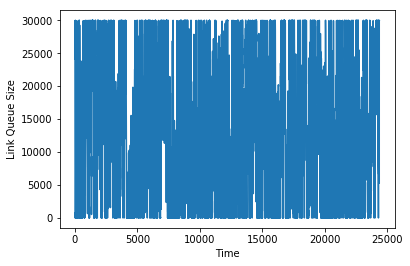

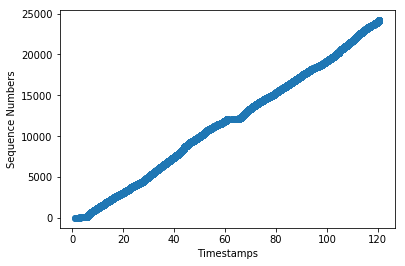

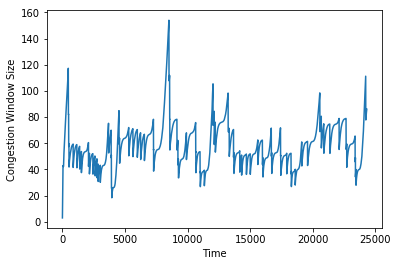

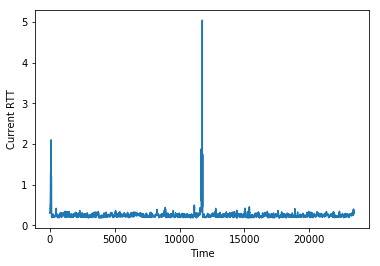

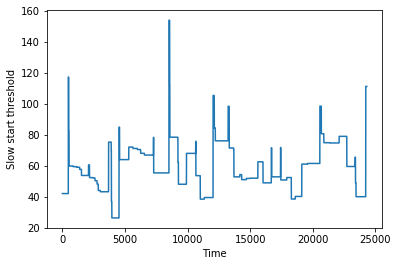


Results for sender 59971:
Total Acks: 12628
Num Duplicate Acks: 366
% duplicate acks: 2.898321
Throughput (bytes/s): 8174.666667
Average RTT (ms): 244.834526


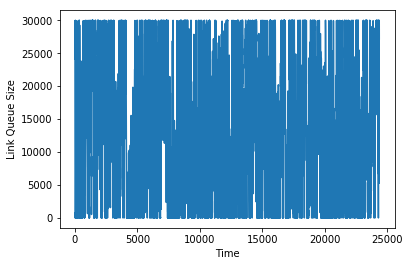

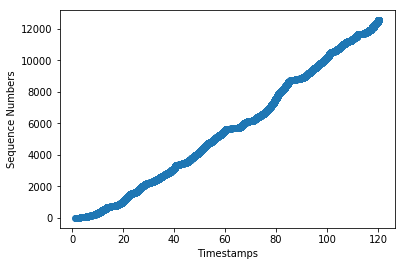

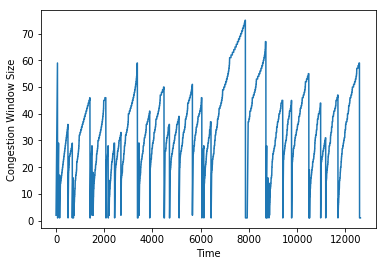

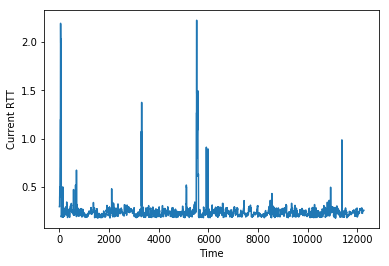

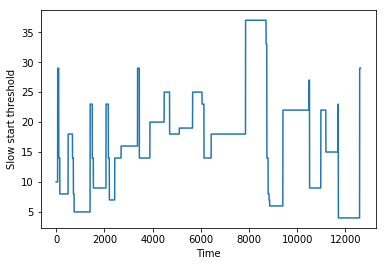

In [6]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port1 = get_open_udp_port()
strat1 = CubicStrategy(4)
port2 = get_open_udp_port()
strat2 = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port1, strat1), Sender(port2, strat2)])

# Fairness - CUBIC vs. Tahoe (Low BDP)

[sender] Connected to receiver: 100.64.0.2:48046

[sender] Connected to receiver: 100.64.0.2:48046

Results for sender 37398:
Total Acks: 62447
Num Duplicate Acks: 2159
% duplicate acks: 3.457332
Throughput (bytes/s): 40192.000000
Average RTT (ms): 484.814198


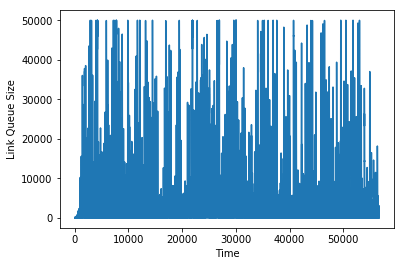

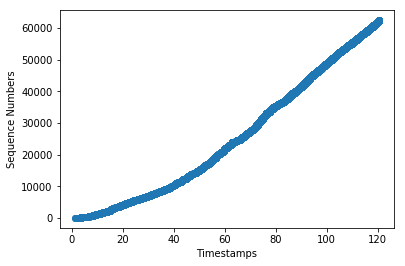

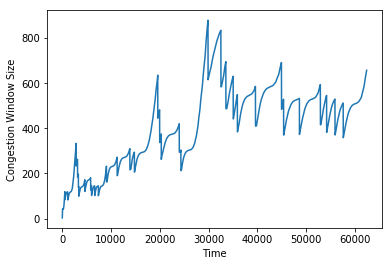

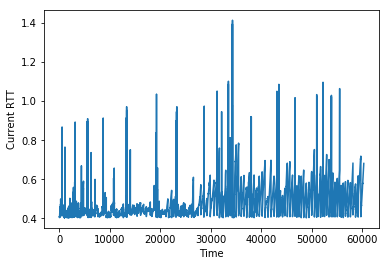

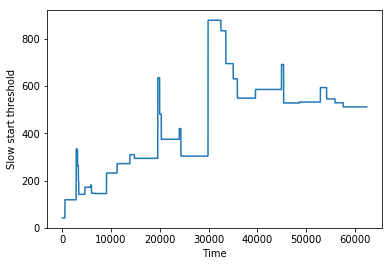


Results for sender 33321:
Total Acks: 14032
Num Duplicate Acks: 152
% duplicate acks: 1.083238
Throughput (bytes/s): 9253.333333
Average RTT (ms): 463.474616


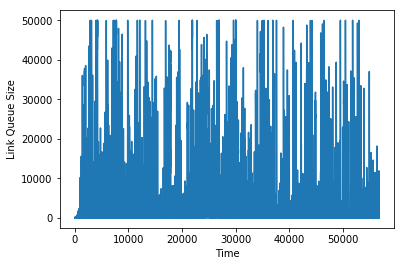

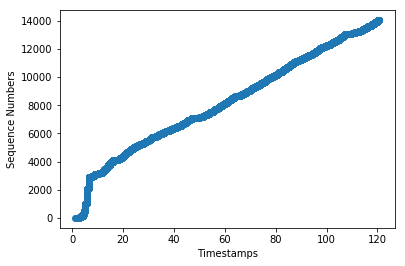

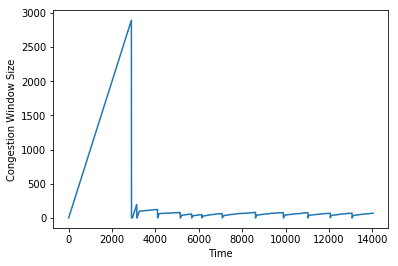

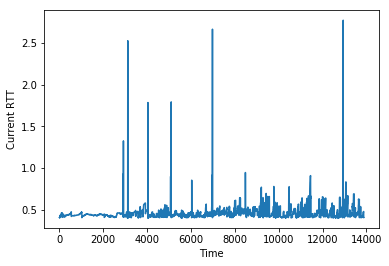

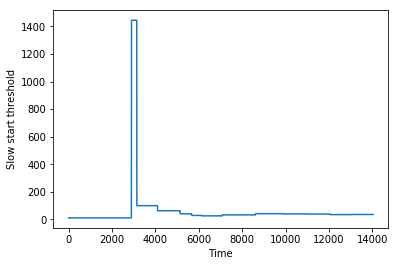

In [7]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port1 = get_open_udp_port()
strat1 = CubicStrategy(4)
port2 = get_open_udp_port()
strat2 = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port1, strat1), Sender(port2, strat2)])